In [59]:
import umap
import math
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.decomposition import DictionaryLearning
from scipy.stats import binom_test

import matplotlib.pyplot as plt

import matplotlib.image as mpimg
import seaborn as sns

from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import cross_val_predict

from contrastive.evaluation.train_multiple_classifiers import compute_auc

In [60]:
# test model
test_model = "/neurospin/dico/jchavas/Runs/57_miccai2023_checks_done_after/Output/contrastive/trained_on_UkBioBank/chosen_model/chosen_model"
# test_model = "/neurospin/dico/data/deep_folding/papers/ipmi2023/models/beta-VAE/n_10/#2"
dataset_train = 'cingulate_UkBioBank_full'

# load the data
train_df = pd.read_csv(test_model+'/'+dataset_train+'_embeddings/train_val_embeddings.csv', index_col=0)
train_df.sort_index(inplace=True)

In [61]:
dataset_test = 'cingulate_ACCpatterns'

test_df = pd.read_csv(test_model+'/'+dataset_test+'_embeddings/cross_val_effective_embeddings.csv', index_col=0)
test_df.sort_index(inplace=True)

# load the labels
prediction_df = pd.read_csv(test_model+'/'+dataset_test+'_embeddings/cross_val_predicted_labels.csv', index_col=0)
prediction_df.sort_index(inplace=True)

In [62]:
len(test_df)

341

## correlation functions

In [63]:
def get_model_by_quality(labels_df, q=0.5):
    aucs = labels_df.apply(compute_auc, args=[labels_df.label])
    aucs = aucs[aucs.index != 'label']
    model_auc = aucs.quantile(q=q, interpolation='nearest')
    aucs = aucs[aucs == model_auc]
    return(aucs.index[0], model_auc)

In [64]:
def cross_correlation(model_path, dataset='cingulate_ACCpatterns_1'):
    # load the data
    data_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/full_embeddings.csv', index_col=0)
    data_df.sort_index(inplace=True)

    prediction_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/cross_val_predicted_labels.csv', index_col=0)
    prediction_df.sort_index(inplace=True)

    full_df = pd.merge(prediction_df[['label']], data_df, left_index=True, right_index=True)

    fig, axs = plt.subplots(1, 4, figsize=(30,10)) 

    latent_df = full_df.iloc[:,1:]
    corr = latent_df.corr()
    axs[0] = sns.heatmap(
            corr, 
            vmin=-1, vmax=1, center=0,
            cmap=sns.diverging_palette(20, 220, n=200),
            square=True,
            ax=axs[0]
            )

    latent_df = full_df[full_df.label == 0].iloc[:,1:]
    corr0 = latent_df.corr()
    axs[1] = sns.heatmap(
            corr0, 
            vmin=-1, vmax=1, center=0,
            cmap=sns.diverging_palette(20, 220, n=200),
            square=True,
            ax=axs[1]
            )

    latent_df = full_df[full_df.label == 1].iloc[:,1:]
    corr1 = latent_df.corr()
    axs[2] = sns.heatmap(
            corr1, 
            vmin=-1, vmax=1, center=0,
            cmap=sns.diverging_palette(20, 220, n=200),
            square=True,
            ax=axs[2]
            )

    corrdiff = (corr1-corr0)
    axs[3] = sns.heatmap(
            corrdiff, 
            vmin=corrdiff.min().min(), vmax=corrdiff.max().max(), center=0,
            cmap=sns.diverging_palette(20, 220, n=200),
            square=True,
            ax=axs[3]
            )


In [65]:
def visualize_each_variable(model_path, display: str, display_err: bool, normalize=True, verbose=False, dataset='cingulate_ACCpatterns_1'):
    '''
    display: str -> takes the values '0', '1', 'all'
    '''
    # load the data
    data_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/full_embeddings.csv', index_col=0)
    data_df.sort_index(inplace=True)

    prediction_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/cross_val_predicted_labels.csv', index_col=0)
    prediction_df.sort_index(inplace=True)

    full_df = pd.merge(prediction_df[['label']], data_df, left_index=True, right_index=True)

    # Chooses to display only labels '0', '1' or all
    if display == '0':
        full_df = full_df[full_df.label == 0]
    elif display == '1':
        full_df = full_df[full_df.label == 1]
    
    # Some prints if verbose true
    if verbose:
        print("Prediction df:")
        print(prediction_df.iloc[:2, :2])
        print(len(prediction_df))
        print(prediction_df[['label']].shape)
        print("Data df:")
        print(len(data_df))
        print(data_df.iloc[:2, :2])
        print(data_df.shape)
        print("Full df:")
        print(len(full_df))
        print(full_df.iloc[:2, :2])
        print(full_df.shape)

    N, D = full_df.shape
    D = D-1 # There is the label column added

    # Initializes plot
    plt.figure(figsize=(16,12))

    # Builds x coordinates for scatter plot
    x = np.reshape(np.arange(D), (1,D))
    x = np.repeat(x, N, axis=0)

    # Replaces labels 0, 1 with colors
    label_df = full_df[['label']].copy()
    label_df['label'] = label_df['label'].astype("str")
    label_df['label'] = label_df['label'].replace('0', 'b')
    label_df['label'] = label_df['label'].replace('1', 'r')

    # Builds colors to match pyplot requirements
    colors = label_df['label'].values
    colors = np.reshape(colors, (1,N))
    colors = np.repeat(colors, D, axis=0)
    colors = colors.T
    print('x, full_df and colors shapes: ', x.shape, full_df.shape, colors.shape)
    colors = np.reshape(colors, (N*D,))

    # latent (doesn't take the first column, which is the label)
    latent_df = full_df.iloc[:,1:]
    mu = latent_df.mean()
    std = latent_df.std()
    if normalize == True:
        latent_df = (latent_df-mu)/std

    # Actual plotting of each point
    plt.scatter(x, latent_df, c=colors, marker='.')

    # Computes averages
    if display == "all":
        # Computes average for label=0
        x = np.arange(D)
        label0_df = full_df[full_df['label'] == 0].iloc[:,1:]
        if normalize == True:   
            label0_df = (label0_df-mu)/std
        mean_df = label0_df.mean()
        e_df = label0_df.std()
        print(x.shape, mean_df.shape, e_df.shape)
        if display_err:
            plt.errorbar(x, mean_df, yerr=e_df, color='blue', linestyle='None', elinewidth=4, marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3, solid_capstyle='projecting', capsize=10)
        else:
            plt.plot(x, mean_df, color='blue', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)

        # Computes average for label=1
        label1_df = full_df[full_df['label'] == 1].iloc[:,1:]
        if normalize == True:   
            label1_df = (label1_df-mu)/std
        mean_df = label1_df.mean()
        e_df = label1_df.std()
        if display_err:
            plt.errorbar(x, mean_df, yerr=e_df, color='red', linestyle='None', elinewidth=4, marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3,solid_capstyle='projecting', capsize=10)
        else:
            plt.plot(x, mean_df, color='red', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)

    # Shows the computed plot
    plt.show()

    return 

In [66]:
def full_visualization(model_path, dataset='cingulate_ACCpatterns_1'):
    plt.figure(figsize=(12.8, 9.6))
    fig = plt.imshow(mpimg.imread(model_path+"/"+dataset+"_embeddings/cross_val_ROC_curves.png"))
    plt.axis('off')
    plt.show()
    return visualize_umaps(model_path, dataset)

In [67]:
# test model
# visual_embs = full_visualization(test_model)

## Visualize each variable of the latent

x, full_df and colors shapes:  (171, 10) (171, 11) (171, 10)
(10,) (10,) (10,)


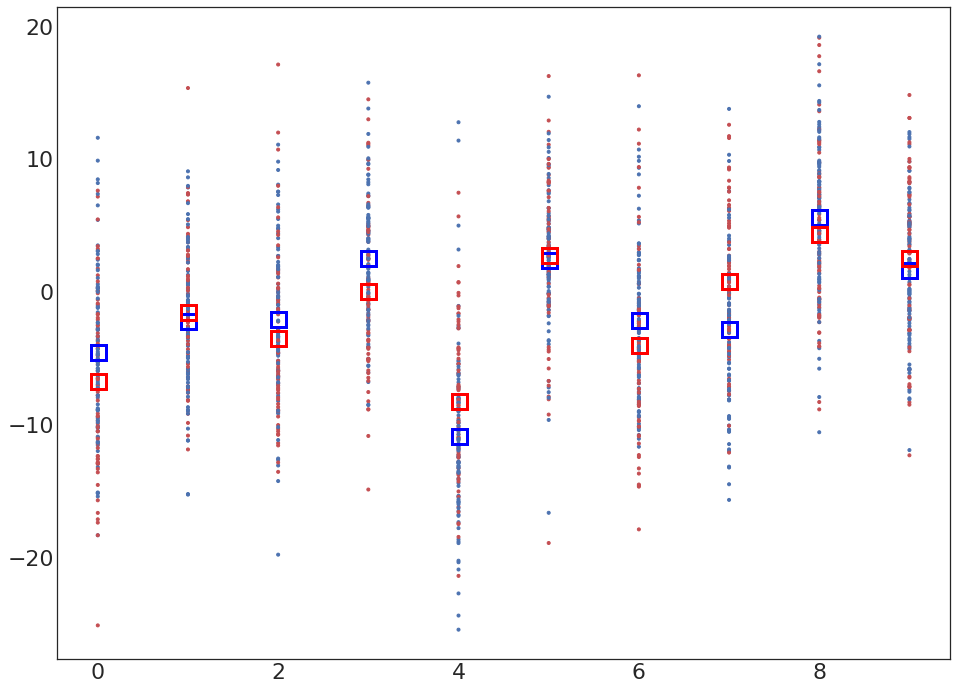

In [68]:
visualize_each_variable(test_model, display='all', display_err=False, normalize=False, verbose=False)

In [69]:
def do_pca(model_path, dataset=dataset_test):
    # load the data
    data_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/full_embeddings.csv', index_col=0)
    data_df.sort_index(inplace=True)

    prediction_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/cross_val_predicted_labels.csv', index_col=0)
    prediction_df.sort_index(inplace=True)

    full_df = pd.merge(prediction_df[['label']], data_df, left_index=True, right_index=True)

    # Makes PCA over all dataframe
    latent_df = full_df.iloc[:,1:]
    latent_df_normalized = (latent_df - latent_df.mean()) / latent_df.std()
    n_components = latent_df.shape[1]
    pca = PCA(n_components=n_components)
    transformed = pca.fit_transform(latent_df_normalized)

    # Transforms over label0 dataframe
    label0_df = full_df[full_df['label'] == 0].iloc[:,1:]
    label0_df = (label0_df - latent_df.mean()) / latent_df.std()
    transformed0 = pca.transform(label0_df)
    mean0 = np.mean(transformed0, axis=0)
    print(mean0.shape)

    # Transforms over label1 dataframe
    label1_df = full_df[full_df['label'] == 1].iloc[:,1:]
    label1_df = (label1_df - latent_df.mean()) / latent_df.std()
    transformed1 = pca.transform(label1_df)
    mean1 = np.mean(transformed1, axis=0)
    print(mean1.shape)

    idx = np.arange(n_components)+1
    explained_variance = pca.explained_variance_ratio_
    cum_explained_variance = np.cumsum(explained_variance)
    df_explained_variance = pd.DataFrame([explained_variance, cum_explained_variance], 
                                     index=['explained variance', 'cumulative'], 
                                     columns=idx).T

    limit_df = n_components

    #make scree plot
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['axes.edgecolor'] = 'black'
    fig, axs = plt.subplots(1, 2, figsize=(30,10)) 
    [t.set_color('white') for t in axs[0].xaxis.get_ticklabels()]
    [t.set_color('white') for t in axs[0].yaxis.get_ticklabels()]
    axs[0].set_title('Explained variance across principal components', fontsize=14)
    axs[0].set_xlabel('Principal component', fontsize=12)
    axs[0].set_ylabel('Explained variance', fontsize=12)
    sns.barplot(ax=axs[0], x=idx[:limit_df], y='explained variance', data=df_explained_variance, palette='summer')
    axs[0] = axs[0].twinx()
    axs[0].grid(False)
    axs[0].set_ylabel('Cumulative', fontsize=14)
    sns.lineplot(ax=axs[0], x=idx[:limit_df]-1, y='cumulative', data=df_explained_variance, color='#fc8d59')

    N, D = transformed.shape
    # Builds x coordinates for scatter plot
    x = np.reshape(np.arange(D), (1,D))
    x = np.repeat(x, transformed0.shape[0], axis=0)
    axs[1].scatter(x, transformed0, c='blue', marker='.')
    x = np.reshape(np.arange(D), (1,D))
    x = np.repeat(x, transformed1.shape[0], axis=0)
    axs[1].scatter(x, transformed1, c='red', marker='.')
    x = np.arange(D)
    axs[1].plot(x, mean0, color='blue', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)
    axs[1].plot(x, mean1, color='red', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)

    plt.show()


In [70]:
def do_dictionary_learning(data_df, n_components=10, transform_n_nonzero_coefs=1):
    data_df_local = data_df.copy()
    full_df_local = pd.DataFrame()
    # Makes dictionary learning over all embeddings
    latent_df = data_df_local.iloc[:,:]
    latent_df_normalized = (latent_df - latent_df.mean()) / latent_df.std()
    n_components = n_components
    dict_learner = DictionaryLearning(n_components=n_components,
                                      transform_n_nonzero_coefs=transform_n_nonzero_coefs,
                                      alpha=1)
    transformed = dict_learner.fit_transform(latent_df_normalized)

    # Adds transform to full_df
    columns = ['trans_'+str(x) for x in range(n_components)]
    transformed_df_local = pd.DataFrame(transformed, columns=columns)
    transformed_df_local.index = data_df_local.index
    full_df_local = pd.merge(data_df_local, transformed_df_local, left_index=True, right_index=True)

    return full_df_local, transformed_df_local, dict_learner

In [71]:
def plot_patterns(prediction_df, transformed_df, random=False):
    # Makes local copy
    prediction_df_local = prediction_df.copy()
    transformed_df_local = transformed_df.copy()

    if random:
        prediction_df_local['label'] = np.random.permutation(prediction_df_local['label'].values)
    full_df_local = pd.merge(prediction_df_local[['label']], transformed_df_local, left_index=True, right_index=True)

    # Transforms over label0 dataframe
    label0_df = full_df_local[full_df_local['label'] == 0].iloc[:,1:]
    transformed0 = label0_df.values

    # Transforms over label1 dataframe
    label1_df = full_df_local[full_df_local['label'] == 1].iloc[:,1:]
    transformed1 = label1_df.values

    fig, axs = plt.subplots(1, 1, figsize=(10,7)) 

    _, D = transformed0.shape

    x = np.reshape(np.arange(D), (1,D))
    x = np.repeat(x, transformed0.shape[0], axis=0)
    axs.scatter(x, transformed0, c='blue', marker='.')
    x = np.reshape(np.arange(D), (1,D))
    x = np.repeat(x, transformed1.shape[0], axis=0)
    axs.scatter(x, transformed1, c='red', marker='.')

    x = np.arange(D)

    masked0 = np.ma.masked_equal(transformed0, 0.)
    mean0 = masked0.mean(axis=0)
    axs.plot(x, mean0, color='blue', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)

    masked1 = np.ma.masked_equal(transformed1, 0.)
    mean1 = masked1.mean(axis=0)
    axs.plot(x, mean1, color='red', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)

    plt.show()

In [72]:
def return_predictions(prediction_df, transformed_df, random=False):
    # Initializes
    prediction_df_local = prediction_df.copy()
    transformed_df_local = transformed_df.copy()
    n_patterns = len(transformed_df_local.columns)
    res = np.zeros(2*n_patterns)

    # Makes random permutation to produce random label
    if random:
        prediction_df_local['label'] = np.random.permutation(prediction_df_local['label'].values)

    full_df_local = pd.merge(prediction_df_local[['label']], transformed_df_local, left_index=True, right_index=True)

    # Makes prediction for each pattern
    for i, c in enumerate(transformed_df_local.columns):
        df = full_df_local[full_df_local[c] < 0.]
        res[2*i] = df['label'].mean()
        df = full_df_local[full_df_local[c] > 0.]
        res[2*i+1] = df['label'].mean()

    return res

def plot_predictions(prediction_df, transformed_df):
    prediction_df_local = prediction_df.copy()
    transformed_df_local = transformed_df.copy()
    n_patterns = len(transformed_df_local.columns)
    x = np.arange(2*n_patterns)
    res_random = np.zeros((20, 2*n_patterns))

    # Loads labels
    mean_label = prediction_df_local['label'].mean()
    print(f"Mean label = {mean_label}")

    # Computes pattern prediction
    res = return_predictions(prediction_df_local, transformed_df_local)
    for i in range(20):
        res_random[i,:] = return_predictions(prediction_df_local, transformed_df_local, True)
    
    for i in range(20):
        plt.scatter(x, res_random[i], c='grey')

    plt.scatter(x, res, c='red')
    plt.plot(mean_label*np.ones(2*n_patterns))
    plt.ylim((0,1))
    return res   

In [73]:
def return_sum(prediction_df, transformed_df, random=False):
    # Initializes
    prediction_df_local = prediction_df.copy()
    transformed_df_local = transformed_df.copy()
    n_patterns = len(transformed_df_local.columns)
    res_sum = np.zeros(2*n_patterns)
    res_len = np.zeros(2*n_patterns)

    full_df = pd.merge(prediction_df_local[['label']], transformed_df_local, left_index=True, right_index=True)

    # Makes prediction for each pattern
    for i, c in enumerate(transformed_df_local.columns):
        df = full_df[full_df[c] < 0.]
        res_sum[2*i] = df['label'].sum()
        res_len[2*i] = len(df)
        df = full_df[full_df[c] > 0.]
        res_sum[2*i+1] = df['label'].sum()
        res_len[2*i+1] = len(df)

    return res_sum, res_len


def do_t_test(prediction_df, transformed_df, show=True, nb_components=10):
    prediction_df_local = prediction_df.copy()
    transformed_df_local = transformed_df.copy()
    n_patterns = len(transformed_df_local.columns)
    x = np.arange(2*n_patterns)
    res_p = np.zeros(2*n_patterns)

    # Mean labels
    mean_label = prediction_df_local['label'].mean()
    # print(f"Mean label = {mean_label}")

    # Computes pattern prediction
    res_sum, res_len = return_sum(prediction_df_local, transformed_df_local)
    
    for i in range(2*n_patterns):
        res_p[i] = binom_test(res_sum[i], n=res_len[i], p=mean_label, alternative='two-sided')

    if show:
        plt.scatter(x, -np.log10(res_p))
        plt.plot(-np.log10(0.05/(2*nb_components))*np.ones(2*n_patterns))

    return res_p   

In [74]:
def give_number_relevant_subjects_accuracy(prediction_df, transformed_df, res_p, show=True, nb_components=10):
    prediction_df_local = prediction_df.copy()
    transformed_df_local = transformed_df.copy()

    df = pd.merge(prediction_df_local[['label']], transformed_df_local, left_index=True, right_index=True)
    nb_subjects = np.zeros(len(res_p))
    nb_subjects_relevant = 0
    exact_nb_subjects_relevant = 0
    log_p_nb_subjects = 0
    max_auc_score = 0.0
    auc_score = np.zeros(len(res_p))
    accuracy = []
    # print(len(df.columns))
    for i in range(1,len(df.columns)):
        # print(df.iloc[:,[i]].columns)
        d = df[df.iloc[:,i] < 0.]
        d = d.copy()
        if 2.*d.label.sum() < (len(d.label)):
            d.iloc[:,i] = 0
        else:
            d.iloc[:,i] = 1
        # print(np.unique(d.label.values).shape)
        nb_subjects[2*i-2] = len(d)
        auc_score[2*i-2] = accuracy_score(d.label, d.iloc[:,i])
        if 2.*d.label.sum() < (len(d.label)):
            exact_nb_subjects = len(d.label)-d.label.sum()
        else:
            exact_nb_subjects = d.label.sum()
        accuracy.append(float(exact_nb_subjects)/len(d.label))
        
        if res_p[2*i-2] < 0.05/nb_components:
            nb_subjects_relevant += nb_subjects[2*i-2]
            max_auc_score = max(auc_score[2*i-2], max_auc_score)
            exact_nb_subjects_relevant += exact_nb_subjects
            log_p_nb_subjects += -np.log10(res_p[2*i-2])*exact_nb_subjects

        d = df[df.iloc[:,i] > 0.]
        d = d.copy()
        if 2.*d.label.sum() < (len(d.label)):
            d.iloc[:,i] = 0
        else:
            d.iloc[:,i] = 1
        nb_subjects[2*i-1] = len(d)
        auc_score[2*i-1] = accuracy_score(d.label, d.iloc[:,i])
        if 2.*d.label.sum() < (len(d.label)):
            exact_nb_subjects = len(d.label)-d.label.sum()
        else:
            exact_nb_subjects = d.label.sum()
        accuracy.append(float(exact_nb_subjects)/len(d.label))
        
        if res_p[2*i-1] < 0.05/nb_components:
            nb_subjects_relevant += nb_subjects[2*i-1]
            max_auc_score = max(auc_score[2*i-1], max_auc_score)
            exact_nb_subjects_relevant += exact_nb_subjects
            log_p_nb_subjects += -np.log10(res_p[2*i-2])*exact_nb_subjects
            
    # print(d)
    if show:
        x = np.arange(len(res_p))
        plt.scatter(x, auc_score)
        plt.ylabel('accuracy_score')
        # plt.scatter(res_p, auc_score)
        # plt.xlabel('p value')
        # plt.ylabel('auc_score')
    return accuracy, nb_subjects_relevant, max_auc_score, exact_nb_subjects_relevant, log_p_nb_subjects

In [75]:
def test_dictionary_learning(dict_learner, test_df, n_components):
    test_df_local = test_df.copy()
    full_df_local = pd.DataFrame()
    latent_df = test_df_local.iloc[:,:]
    latent_df_normalized = (latent_df - latent_df.mean()) / latent_df.std()
    transformed = dict_learner.transform(latent_df_normalized)

    # Adds transform to full_df
    columns = ['trans_'+str(x) for x in range(n_components)]
    transformed_df_local = pd.DataFrame(transformed, columns=columns)
    transformed_df_local.index = test_df_local.index
    full_df_local = pd.merge(test_df_local, transformed_df_local, left_index=True, right_index=True)

    return full_df_local, transformed_df_local


## Non-zeros=1, nb_components=4

In [76]:
%env NUMEXPR_MAX_THREADS=46

env: NUMEXPR_MAX_THREADS=46


In [77]:
full_df, transformed_train_df, dict_learner = do_dictionary_learning(data_df=train_df, n_components=4, transform_n_nonzero_coefs=1)

In [78]:
full_df, transformed_df = test_dictionary_learning(dict_learner=dict_learner, test_df=test_df, n_components=4)

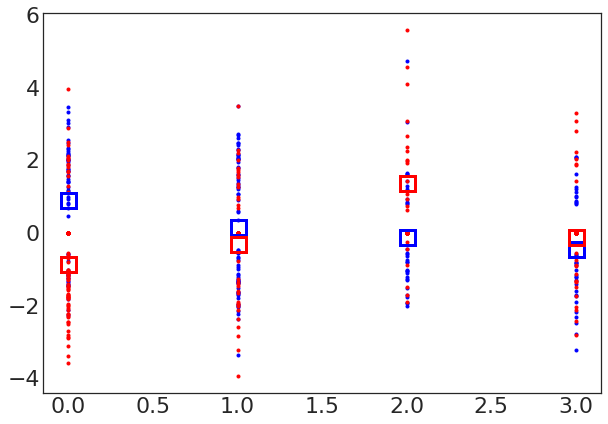

In [79]:
plot_patterns(prediction_df, transformed_df, random=False)

In [80]:
# plot_patterns(prediction_df, transformed_df, random=True)

In [81]:
def plot_patterns_separated(prediction_df, transformed_df, random=False):
    # Makes local copy
    prediction_df_local = prediction_df.copy()
    transformed_df_local = transformed_df.copy()

    if random:
        prediction_df_local['label'] = np.random.permutation(prediction_df_local['label'].values)
    full_df_local = pd.merge(prediction_df_local[['label']], transformed_df_local, left_index=True, right_index=True)

    l = len(full_df_local)
    d = len(full_df_local.columns)
    res = pd.DataFrame(np.zeros((l,3)), index=full_df_local.index, columns=["val", "label", "pat"])
    patterns = ["Ap", "Am", "Bp", "Bm", "Cp", "Cm", "Dp", "Dm"]

    for index, row in transformed_df_local.iterrows():
        idx_nonzero = int(np.nonzero(row.values)[0])
        val_nonzero = row.iloc[idx_nonzero]
        res.loc[index, "val"] = np.abs(val_nonzero)
        res.loc[index, "label"] = prediction_df_local.loc[index, "label"]
        if val_nonzero > 0.:
            res.loc[index, "pat"] = patterns[2*idx_nonzero]
        else:
            res.loc[index, "pat"] = patterns[2*idx_nonzero+1]

    res.sort_values(ascending=True, by='pat', inplace=True)

    f, ax = plt.subplots(1, 1, figsize=(10, 5))
    # g = sns.pointplot(data=res, x=res.pat, y="val", hue = "label", alpha=[0.5,0.5], palette=['blue', 'red'], markers=['v', 's'], scale=2, linestyles=['None', 'None'], ax=ax)
    # plt.setp(g.collections, alpha=0.5)
    # plt.setp(g.lines, alpha=.5) 
    sns.stripplot(data=res[res.label==0], x=res.pat, y="val", hue = "label", marker='v', palette=['blue'], size=7, jitter=.2, ax=ax)
    sns.stripplot(data=res[res.label==1], x=res.pat, y="val", hue = "label", marker='s', palette=['red'], size=7, jitter=.2, ax=ax)
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend([handles[1], handles[0]], ["paracingular", "no paracingular"], labelspacing=2)

    plt.show()

    return res

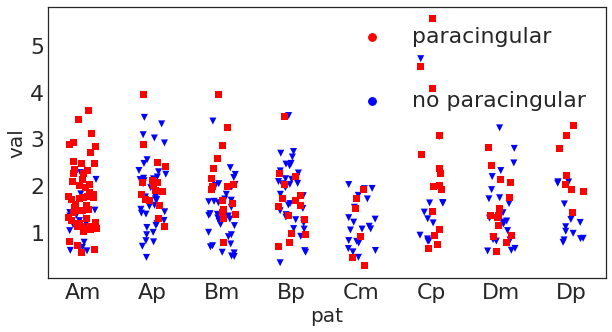

In [82]:
res_df = plot_patterns_separated(prediction_df, transformed_df)

In [83]:
res_df2 = res_df.copy()
res_df2["atom"] = res_df2["pat"].apply(lambda x: x[0])
res_df2["sign"] = res_df2["pat"].apply(lambda x: x[1])
res_df2.rename(columns={"label": "pattern type"}, inplace=True)
res_df2["pattern type"] = res_df2["pattern type"].apply(lambda x: "parallel" if x== 1.0 else "single")
# res_df2.sort_values(ascending=True, by='atom', inplace=True)
# res_df2.sort_values(ascending=False, by='sign', inplace=True)
res_df2 = res_df2.sort_values(['atom', 'sign'], ascending=[True, False])
res_df2.drop(columns="pat", inplace=True)

In [84]:
res_df2.head()

,val,pattern type,atom,sign
Subject,,,,
sub-inhibition07_ses-pretraining_T1w,2.152035,single,A,p
nih_chp_02993_t1,1.697740,parallel,A,p
nih_chp_03319_t1,0.939045,single,A,p
nih_chp_05190_t1,1.404305,single,A,p
sub-inhibition14_ses-pretraining_T1w,1.114841,parallel,A,p


['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


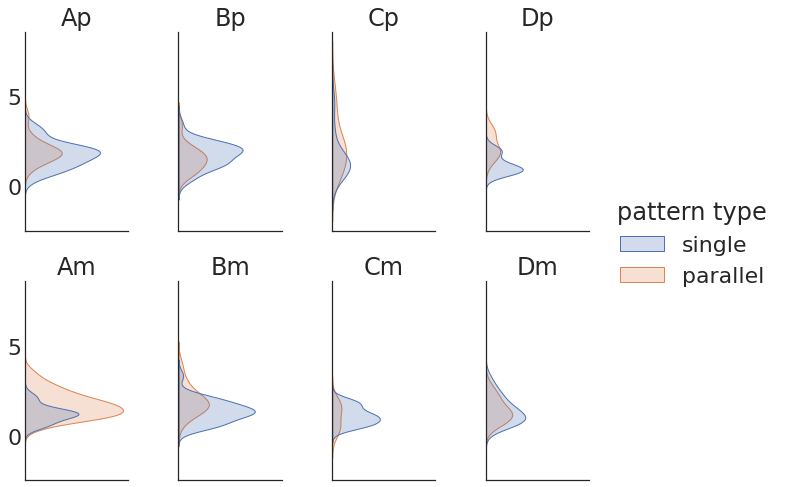

In [85]:
sns.set(font_scale=2)
print(plt.style.available)
plt.style.use('seaborn-white')
g = sns.displot(
    data=res_df2, y="val", hue="pattern type", col="atom", row="sign",
    fill=True,
    kind="kde", height=4, aspect=.6,
)
g.set_axis_labels("", "")
g.set_titles("{col_name}{row_name}", loc='center')
g.set(xticklabels=[])
# plt.setp(g._legend.get_title(), fontsize=30)

In [86]:
def plot_patterns_separated_without_labels(transformed_df, random=False):
    # Makes local copy
    transformed_df_local = transformed_df.copy()
    full_df_local = transformed_df_local

    l = len(full_df_local)
    d = len(full_df_local.columns)
    res = pd.DataFrame(np.zeros((l,3)), index=full_df_local.index, columns=["val", "label", "pat"])
    patterns = ["Am", "Ap", "Bm", "Bp", "Cm", "Cp", "Dm", "Dp"]

    for index, row in transformed_df_local.iterrows():
        idx_nonzero = int(np.nonzero(row.values)[0])
        val_nonzero = row.iloc[idx_nonzero]
        res.loc[index, "val"] = np.abs(val_nonzero)
        res.loc[index, "label"] = 0
        if val_nonzero < 0.:
            res.loc[index, "pat"] = patterns[2*idx_nonzero]
        else:
            res.loc[index, "pat"] = patterns[2*idx_nonzero+1]

    res.sort_values(ascending=True, by='pat', inplace=True)

    f, ax = plt.subplots(1, 1, figsize=(10, 5))
    g = sns.pointplot(data=res, x=res.pat, y="val", hue = "label", alpha=[0.5,0.5], palette=['blue', 'red'], markers=['v', 's'], scale=2, linestyles=['None', 'None'], ax=ax)
    plt.setp(g.collections, alpha=0.5)
    # plt.setp(g.lines, alpha=.5) 
    sns.stripplot(data=res[res.label==0], x=res.pat, y="val", hue = "label", marker='v', palette=['blue'], jitter=.1, ax=ax)
    # sns.stripplot(data=res[res.label==1], x=res.pat, y="val", hue = "label", marker='s', palette=['red'], jitter=.1, ax=ax)
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend([],[], frameon=False)
    
    plt.show()

    return res

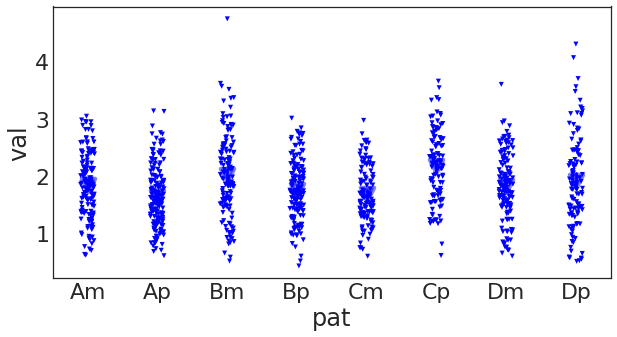

In [87]:
res_train_df = plot_patterns_separated_without_labels(transformed_train_df)

In [88]:
def plotting_hist(res_df):
    patterns = ["Am", "Ap", "Bm", "Bp", "Cm", "Cp", "Dm", "Dp"]

    plt.rc('axes', labelsize=14) 
    f, axs = plt.subplots(4, 2, figsize=(11, 22))

    for i, pat in enumerate(patterns):
        axs[i%4,int(i/4)].hist(res_df[(res_df.label==0) & (res_df.pat==pat)].val, alpha=0.5)
        axs[i%4,int(i/4)].hist(res_df[(res_df.label==1) & (res_df.pat==pat)].val, alpha=0.5)

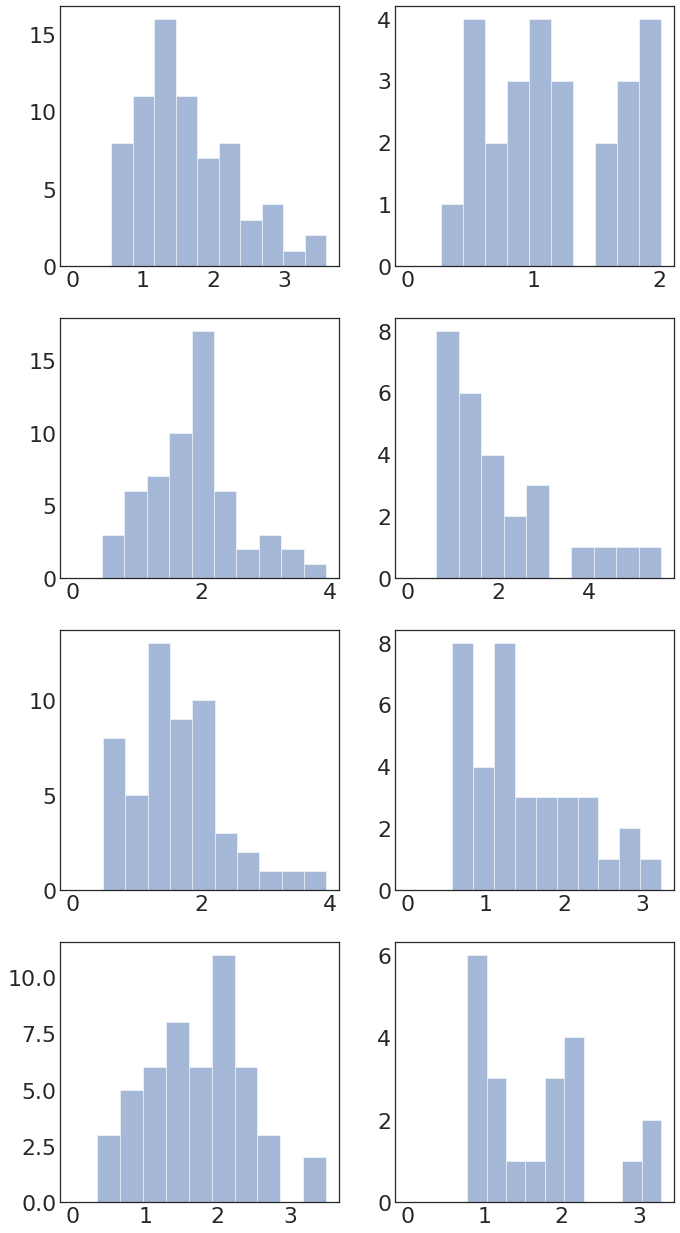

In [89]:
res0_df = res_df.copy()
res0_df.label=0
plotting_hist(res0_df)

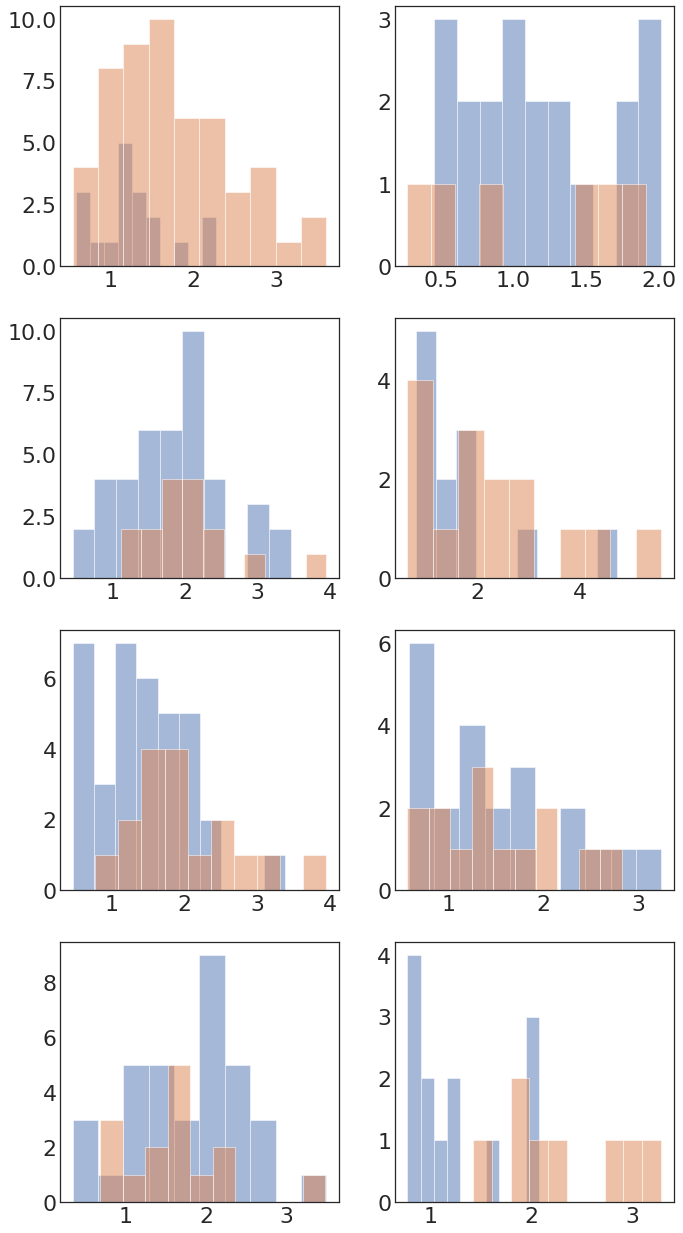

In [90]:
plotting_hist(res_df)

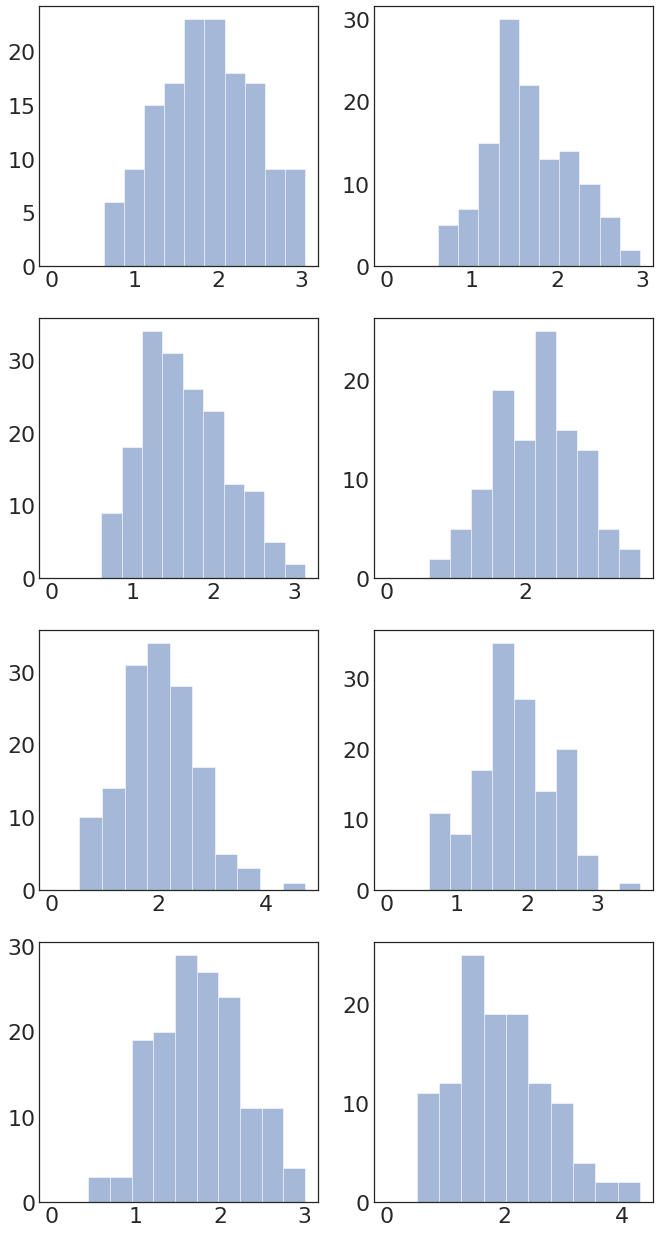

In [91]:
plotting_hist(res_train_df)

Mean label = 0.4222873900293255


array([0.74647887, 0.28070175, 0.32075472, 0.3       , 0.23076923,
       0.55555556, 0.38888889, 0.38095238])

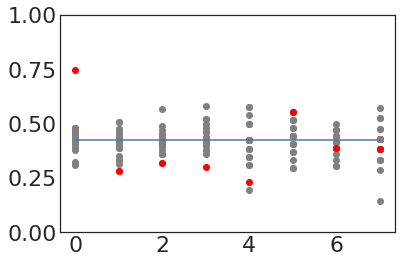

In [92]:
plot_predictions(prediction_df, transformed_df)

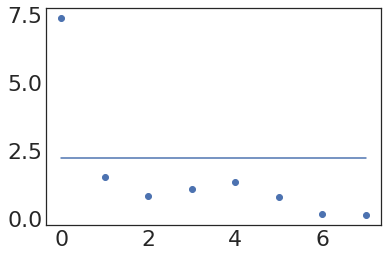

In [93]:
res_p = do_t_test(prediction_df, transformed_df, nb_components=4)

In [94]:
res_p

array([4.26579995e-08, 3.19044724e-02, 1.64031421e-01, 8.66543532e-02,
       4.92759899e-02, 1.75872412e-01, 7.38252108e-01, 8.26516131e-01])

([0.7464788732394366, 0.7192982456140351, 0.6792452830188679, 0.7, 0.7692307692307693, 0.5555555555555556, 0.6111111111111112, 0.6190476190476191], 71.0, 0.7464788732394366, 53, 390.609974318254)


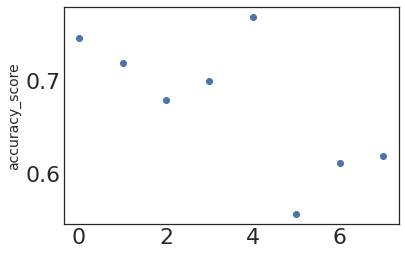

In [95]:
ret_nb_subjects = give_number_relevant_subjects_accuracy(prediction_df, transformed_df, res_p, nb_components=4)
print(ret_nb_subjects)
accuracy = ret_nb_subjects[0]

In [96]:
def plot_manhattan(prediction_df, transformed_df, accuracy, ax):
    labelsize=16
    ax.xaxis.set_tick_params(labelsize = labelsize)
    ax.yaxis.set_tick_params(labelsize = labelsize)
    nb_components = 2*len(transformed_df.columns)
    res_p = do_t_test(prediction_df,
                      transformed_df,
                      show=False,
                      nb_components=nb_components)
    print(res_p)

    markerline, stemlines, baseline = \
        ax.stem(["Am", "Ap", "Bm", "Bp", "Cm", "Cp", "Dm", "Dp"],
              -np.log10(res_p),
              basefmt= 'C0',
              linefmt=':')
    plt.setp(markerline, 'color', 'black')
    plt.setp(stemlines, 'color', 'black')
    plt.setp(baseline, 'color', 'black')
    ax.plot(-np.log10(0.05/(nb_components))*np.ones(nb_components), c='black')
    ax.set_ylabel("-log$_{10}$(p)", labelpad=5.0)
    ax.set_xlabel("folding atoms", labelpad=10.0)
    ax2 = ax.twinx()
    ax2.xaxis.set_tick_params(labelsize = labelsize)
    ax2.yaxis.set_tick_params(labelsize = labelsize)
    ax2.plot(["Am", "Ap", "Bm", "Bp", "Cm", "Cp", "Dm", "Dp"],accuracy, c='blue')
    ax2.set_ylim([0.,1.52])
    ax2.set_ylabel('accuracy', color='b', rotation=270, labelpad=25)
    ax2.set_yticks([0., 0.5, 1.0])
    ax2.spines['right'].set_color('blue')
    ax2.tick_params(axis='y', colors='blue')
    ax2.set_ylim(-0.08)


[4.26579995e-08 3.19044724e-02 1.64031421e-01 8.66543532e-02
 4.92759899e-02 1.75872412e-01 7.38252108e-01 8.26516131e-01]


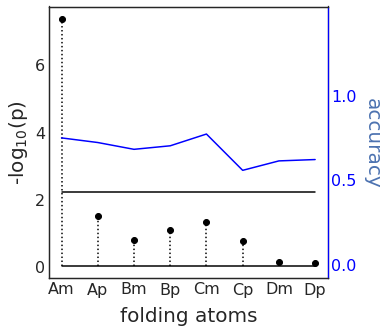

In [97]:
plt.rc('axes', labelsize=20) 
f, ax = plt.subplots(1, 1, figsize=(5, 5))
plot_manhattan(prediction_df, transformed_df, accuracy, ax)
plt.show()


## Visualize umap

In [98]:
def compute_umap(df):
    # apply umap
    reducer = umap.UMAP()
    visual_embs = reducer.fit_transform(df)
    return visual_embs, reducer

In [123]:
def display_umaps_true_labels(visual_embs_train, reducer, test_df, prediction_df, verbose=False, title="True labels"):
    if verbose:
        print("Test df:")
        print(test_df[:5])
        print("Prediction df:")
        print(prediction_df[:5])

    # apply umap
    if verbose:
        print("UMAP embeddings")
        print(visual_embs_train.shape)
        print(visual_embs_train[:5])
    visual_embs_test = reducer.transform(test_df)

    ## plot the graphs

    plt.figure()
    plt.scatter(visual_embs_train[:,0], visual_embs_train[:,1], c='green', alpha=0.1)

    # plot for true labels
    cmap = ['b', 'r']
    colors = [cmap[i] for i in prediction_df.label]

    plt.scatter(visual_embs_test[:,0], visual_embs_test[:,1], c=colors, alpha=0.6)
    plt.title(title)
    plt.show()
    
    plt.show()

    return pd.DataFrame(visual_embs_test, index=test_df.index.values)

In [100]:
test_df

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10
ID,,,,,,,,,,
1-03HUBJO_t0,-5.754253,3.078586,-7.888584,0.087529,-0.789996,5.483637,-13.182101,-0.121508,5.131477,8.060051
1-08ANDTI_t0,1.088328,-11.042294,-14.992330,-4.669141,-10.526248,2.802538,2.753804,11.640773,9.842704,-3.447931
1-11LEBJO_t0,-1.836876,-8.145627,-11.142085,-6.752227,-8.926461,9.820431,-1.027278,18.260162,20.029728,-8.143515
1-15LEHMI_t0,-11.456051,4.063096,-7.979030,5.857479,1.790742,0.411421,12.011239,-3.431442,8.380008,14.502483
1-17COLMA_t0,-0.297105,2.693733,-4.022460,7.794108,-3.994520,4.481436,6.465611,-12.552568,10.662281,9.809521
...,...,...,...,...,...,...,...,...,...,...
sub-inhibition25_ses-pretraining_T1w,-1.684906,15.352005,1.378257,-0.692726,7.466899,-18.919360,11.160981,3.726610,0.271897,0.562565
sub-inhibition26_ses-pretraining_T1w,-2.067286,2.819577,6.254409,14.397526,-1.960794,-11.483945,4.744481,-0.441851,5.406650,-5.866943
sub-inhibition28_ses-pretraining_T1w,-4.648675,-0.605071,-3.208010,-2.231013,-5.624875,5.465551,-5.674643,-2.418177,1.359396,5.115456


In [101]:
visual_embs, reducer = compute_umap(test_df)

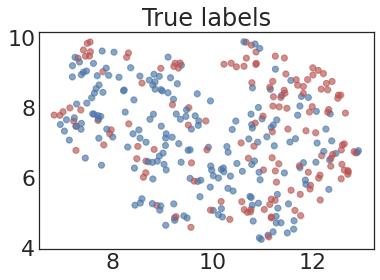

In [124]:
df_umap = display_umaps_true_labels(visual_embs, reducer, test_df, prediction_df, verbose=False)

In [103]:
transformed_df.head()

,trans_0,trans_1,trans_2,trans_3
ID,,,,
1-03HUBJO_t0,-1.810637,0.000000,0.0,0.000000
1-08ANDTI_t0,0.000000,-2.848136,0.0,0.000000
1-11LEBJO_t0,0.000000,-3.948267,0.0,0.000000
1-15LEHMI_t0,0.000000,0.000000,0.0,-3.235225
1-17COLMA_t0,0.000000,0.000000,0.0,-2.317227


In [104]:
transformed_df2 = transformed_df.copy()

In [117]:
transformed_df2["label"] = transformed_df.trans_0.apply(lambda x: 1 if x < 0. else 0)

In [118]:
transformed_df2.head()

,trans_0,trans_1,trans_2,trans_3,label
ID,,,,,
1-03HUBJO_t0,-1.810637,0.000000,0.0,0.000000,1
1-08ANDTI_t0,0.000000,-2.848136,0.0,0.000000,0
1-11LEBJO_t0,0.000000,-3.948267,0.0,0.000000,0
1-15LEHMI_t0,0.000000,0.000000,0.0,-3.235225,0
1-17COLMA_t0,0.000000,0.000000,0.0,-2.317227,0


In [122]:
print(prediction_df.label.sum())
print(transformed_df2.label.sum())

144
71


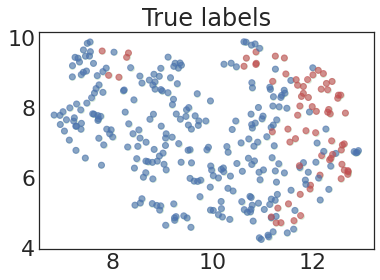

In [119]:
df_umap = display_umaps_true_labels(visual_embs, reducer, test_df, transformed_df2, verbose=False, title="")

## Correspondance des sujets ACCpatterns

In [110]:
transformed_df2[transformed_df2.label==1].index

Index(['1-18ROUCO_t0', '2-08BESAG_t0', '2-14COEEN_t0', 'a0004_t1_s03',
       'a0031_t1_s03', 'a0040_t1_s03', 'e0039_t1_s03', 'e0041_t1_s03',
       'e0051_t1_s03', 'e0061_t1_s03', 'e0063_t1_s03', 'e0066_t1_s03',
       'e0068_t1_s03', 'e0071_t1_s03', 'nih_chp_00551_t1', 'nih_chp_01052_t1',
       'nih_chp_01149_t1', 'nih_chp_01363_t1', 'nih_chp_01746_t1',
       'nih_chp_01967_t1', 'nih_chp_02307_t1', 'nih_chp_02769_t1',
       'nih_chp_03811_t1', 'nih_chp_03812_t1', 'nih_chp_04201_t1',
       'nih_chp_04338_t1', 'nih_chp_04438_t1', 'nih_chp_04568_t1',
       'nih_chp_04778_t1', 'nih_chp_04807_t1', 'nih_chp_04888_t1',
       'nih_chp_04911_t1', 'nih_chp_05132_t1', 'nih_chp_05234_t1',
       'nih_chp_05243_t1', 'nih_chp_05600_t1', 'nih_chp_05652_t1',
       'nih_chp_05720_t1', 'nih_chp_05752_t1',
       'sub-active02_ses-pretraining_T1w', 'sub-active06_ses-pretraining_T1w',
       'sub-active08_ses-pretraining_T1w', 'sub-active10_ses-pretraining_T1w',
       'sub-active14_ses-pretraini

In [111]:
transformed_df2[transformed_df2.label==1]

,trans_0,trans_1,trans_2,trans_3,label
ID,,,,,
1-18ROUCO_t0,0.0,2.020126,0.0,0.0,1
2-08BESAG_t0,0.0,2.129781,0.0,0.0,1
2-14COEEN_t0,0.0,1.578872,0.0,0.0,1
a0004_t1_s03,0.0,2.310189,0.0,0.0,1
a0031_t1_s03,0.0,2.019034,0.0,0.0,1
a0040_t1_s03,0.0,2.456026,0.0,0.0,1
e0039_t1_s03,0.0,1.249462,0.0,0.0,1
e0041_t1_s03,0.0,1.778313,0.0,0.0,1
e0051_t1_s03,0.0,0.932698,0.0,0.0,1


In [112]:
prediction_df[transformed_df2.label==1]

,label,svm_0,svm_1,svm_2,svm_3,svm_4,svm_5,svm_6,svm_7,svm_8,...,svm_243,svm_244,svm_245,svm_246,svm_247,svm_248,svm_249,median_pred,mean_pred,average_model
Subject,,,,,,,,,,,,,,,,,,,,,
1-18ROUCO_t0,0,0.056859,0.065804,0.059742,0.063869,0.054570,0.052025,0.085656,0.062499,0.073759,...,0.103482,0.056832,0.091219,0.060728,0.071737,0.074255,0.048211,0.069571,0.071679,0.084655
2-08BESAG_t0,0,0.359789,0.374236,0.365797,0.371196,0.376201,0.373467,0.389163,0.364050,0.376756,...,0.386878,0.386085,0.375700,0.362606,0.390625,0.373553,0.358397,0.371141,0.371496,0.381192
2-14COEEN_t0,0,0.455414,0.465528,0.461097,0.462988,0.478853,0.477476,0.472004,0.454652,0.463340,...,0.459820,0.489740,0.451720,0.454104,0.482448,0.458871,0.461051,0.458736,0.459428,0.462403
a0004_t1_s03,0,0.366894,0.381091,0.372905,0.378074,0.383891,0.381241,0.395456,0.370813,0.383278,...,0.392430,0.393903,0.381446,0.369428,0.397590,0.379970,0.365995,0.377541,0.378091,0.387337
a0031_t1_s03,0,0.189587,0.208123,0.195222,0.204756,0.194124,0.190057,0.233831,0.200131,0.217135,...,0.247309,0.200891,0.232058,0.197621,0.221567,0.216120,0.179273,0.210221,0.211011,0.229146
a0040_t1_s03,0,0.388759,0.368464,0.381829,0.381991,0.381724,0.377093,0.382736,0.395126,0.375768,...,0.373517,0.392967,0.390961,0.376394,0.389876,0.389319,0.360181,0.387383,0.386633,0.393623
e0039_t1_s03,0,0.378137,0.356191,0.370432,0.370814,0.371089,0.365535,0.370414,0.381123,0.362792,...,0.360333,0.380854,0.379447,0.364011,0.380811,0.376941,0.345351,0.375294,0.374716,0.381672
e0041_t1_s03,0,0.176167,0.136142,0.158923,0.162163,0.169771,0.152679,0.147160,0.135809,0.133249,...,0.128963,0.158401,0.165064,0.141184,0.201691,0.151822,0.101072,0.155110,0.157077,0.161182
e0051_t1_s03,1,0.465247,0.474811,0.470850,0.472345,0.489260,0.488042,0.480346,0.463938,0.472131,...,0.467178,0.500000,0.459444,0.463492,0.491674,0.467555,0.471615,0.467835,0.468410,0.470625


In [113]:
prediction_df[transformed_df2.trans_1 > 0.]

,label,svm_0,svm_1,svm_2,svm_3,svm_4,svm_5,svm_6,svm_7,svm_8,...,svm_243,svm_244,svm_245,svm_246,svm_247,svm_248,svm_249,median_pred,mean_pred,average_model
Subject,,,,,,,,,,,,,,,,,,,,,
1-18ROUCO_t0,0,0.056859,0.065804,0.059742,0.063869,0.054570,0.052025,0.085656,0.062499,0.073759,...,0.103482,0.056832,0.091219,0.060728,0.071737,0.074255,0.048211,0.069571,0.071679,0.084655
2-08BESAG_t0,0,0.359789,0.374236,0.365797,0.371196,0.376201,0.373467,0.389163,0.364050,0.376756,...,0.386878,0.386085,0.375700,0.362606,0.390625,0.373553,0.358397,0.371141,0.371496,0.381192
2-14COEEN_t0,0,0.455414,0.465528,0.461097,0.462988,0.478853,0.477476,0.472004,0.454652,0.463340,...,0.459820,0.489740,0.451720,0.454104,0.482448,0.458871,0.461051,0.458736,0.459428,0.462403
a0004_t1_s03,0,0.366894,0.381091,0.372905,0.378074,0.383891,0.381241,0.395456,0.370813,0.383278,...,0.392430,0.393903,0.381446,0.369428,0.397590,0.379970,0.365995,0.377541,0.378091,0.387337
a0031_t1_s03,0,0.189587,0.208123,0.195222,0.204756,0.194124,0.190057,0.233831,0.200131,0.217135,...,0.247309,0.200891,0.232058,0.197621,0.221567,0.216120,0.179273,0.210221,0.211011,0.229146
a0040_t1_s03,0,0.388759,0.368464,0.381829,0.381991,0.381724,0.377093,0.382736,0.395126,0.375768,...,0.373517,0.392967,0.390961,0.376394,0.389876,0.389319,0.360181,0.387383,0.386633,0.393623
e0039_t1_s03,0,0.378137,0.356191,0.370432,0.370814,0.371089,0.365535,0.370414,0.381123,0.362792,...,0.360333,0.380854,0.379447,0.364011,0.380811,0.376941,0.345351,0.375294,0.374716,0.381672
e0041_t1_s03,0,0.176167,0.136142,0.158923,0.162163,0.169771,0.152679,0.147160,0.135809,0.133249,...,0.128963,0.158401,0.165064,0.141184,0.201691,0.151822,0.101072,0.155110,0.157077,0.161182
e0051_t1_s03,1,0.465247,0.474811,0.470850,0.472345,0.489260,0.488042,0.480346,0.463938,0.472131,...,0.467178,0.500000,0.459444,0.463492,0.491674,0.467555,0.471615,0.467835,0.468410,0.470625
